In [1]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj

In [5]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import seaborn as sns
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
import climateservaccess as ca
from scipy.spatial import KDTree
from shapely.geometry import Point

# Calculate the path to the scripts folder relative to the current notebook.
scripts_dir = Path("../../").resolve()

# Add the scripts directory to the sys.path if it's not already there.
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

# Define datatype and region
datatype_num = 661
datatype = ca.datatypeDict[datatype_num]
REGION = "gambia"
DATE = "12-01-2023"
datatype

'LIS_ET'

### We create a code to know what is inside the file .nc, wich variables how many data, etc. 

In [6]:
def analyze_nasadem_file(file_path: str) -> list:
    """
    Analyze a NetCDF file and print out its contents, such as variable names,
    dimensions, and min/max values for longitude and latitude.

    Args:
    file_path (str): The path to the NASADEM NetCDF file.
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    # Open the NetCDF file
    dataset = nc.Dataset(file_path, 'r')

    # Print general information about the file
    print('')
    print(f"Analyzing file: {file_path}")
    print("Variables in this file:")
    for var in dataset.variables:
        print(f" - {var}: {dataset.variables[var].dimensions}, {dataset.variables[var].shape}")

    # Check for common variables like longitude and latitude
    if 'lon' in dataset.variables and 'lat' in dataset.variables:
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        print(f"Longitude range: {np.min(lon)} to {np.max(lon)}")
        print(f"Latitude range: {np.min(lat)} to {np.max(lat)}")
    
    return list(dataset.variables.keys())

    # Close the dataset
    dataset.close()

# Paths to your files
file_paths = [
    f'../../data/original_data/climateserv/area_of_interest_1/{DATE}/{datatype}.nc',
]

# Analyze each file
for path in file_paths:
    variables = analyze_nasadem_file(file_path=path)

data_var_name = variables[-1] # Assumes last variable is the data variable


Analyzing file: ../../data/original_data/climateserv/area_of_interest_1/12-01-2023/LIS_ET.nc
Variables in this file:
 - time: ('time',), (1,)
 - latitude: ('latitude',), (15,)
 - longitude: ('longitude',), (9,)
 - Evapotranspiration: ('time', 'latitude', 'longitude'), (1, 15, 9)


### After we know what its inside the file, we process him, converting into a DataFrame and saving as CSV.

In [7]:
def load_data_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Loads data from a NetCDF file, removes the 'time' column, 
    drops rows with NaN in data_var_name, and converts it to a Pandas DataFrame.

    Args:
        file_path (str): Path to the NetCDF file.

    Returns:
        pd.DataFrame: DataFrame containing the data with the modifications applied.
    """
    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Select the data_var_name variable and the first time point
    data = ds[data_var_name].isel(time=0)

    # Convert to DataFrame
    df = data.to_dataframe().reset_index()

    # Drop the 'time' column
    df = df.drop(columns=['time'])

    # Drop rows where data_var_name is NaN
    df = df.dropna(subset=[data_var_name])

    return df

def save_dataframe_to_csv(dataframe: pd.DataFrame, output_path: str) -> None:
    """
    Saves the given DataFrame to a CSV file.

    Args:
        dataframe (pd.DataFrame): DataFrame to be saved.
        output_path (str): Path where the CSV file will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save the DataFrame to a CSV file
    dataframe.to_csv(output_path, index=False)

In [8]:
# Usage
file_path = f'../../data/original_data/climateserv/area_of_interest_1/{DATE}/{datatype}.nc'
output_path = '../data/processed_data/climateserv/{datatype}_data.csv'

df_climateserv = load_data_to_dataframe(file_path=file_path)
# rename latitude and longitude columns to lat and lon
df_climateserv = df_climateserv.rename(columns={'latitude': 'lat', 'longitude': 'lon'})
df_climateserv.head()
# save_dataframe_to_csv(dataframe=df_climateserv, output_path=output_path)

,lat,lon,Evapotranspiration
20,13.135,-16.755,2.358303
21,13.135,-16.725,2.000822
29,13.165,-16.755,1.849221
30,13.165,-16.725,0.917022
31,13.165,-16.695,1.836850


### Finally we see what its inside the file to check.

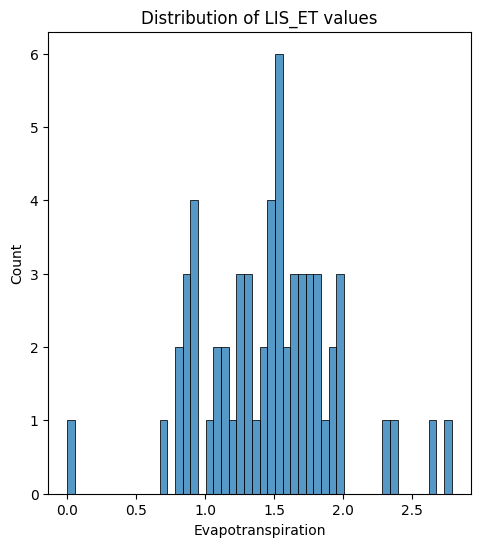

In [9]:
def plot_distribution(df):
    """
    Plots the distribution of values in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing NASADEM_HGT values.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Histogram of NASADEM_HGT values excluding NaNs
    plt.subplot(1, 2, 1)
    sns.histplot(df[data_var_name].dropna(), kde=False, bins=50)
    plt.title(f'Distribution of {datatype} values')
    plt.xlabel(data_var_name)
    plt.ylabel('Count')

# Call the function with your DataFrame
plot_distribution(df_climateserv)

### Here, we will merge this data with the dataframe we have with information of the differents points with lat and long.

In [10]:
df = pd.read_csv("../../data/final_dataset/processed_data/merged_data.csv")

df

,Date,long,lat,Drainage_density,Slope_tif2,Hydrogeo,Curvatu_tif2,NASADEM_HGT,DepthToGroundwater,LIS_ET,NASA_IMERG_Late
0,12-01-2023,-16.670616,13.488346,13.499496,0.000000,5.0,-0.000000e+00,0.0,0-7,1.766242,0.0
1,12-01-2023,-16.665998,13.488376,14.573664,0.000000,5.0,-0.000000e+00,0.0,0-7,1.766242,0.0
2,12-01-2023,-16.684438,13.483734,15.609715,0.000000,5.0,-0.000000e+00,0.0,0-7,1.252523,0.0
3,12-01-2023,-16.679820,13.483765,13.571120,0.000000,5.0,-0.000000e+00,0.0,0-7,1.766242,0.0
4,12-01-2023,-16.675202,13.483796,13.922873,0.000000,5.0,-0.000000e+00,0.0,0-7,1.766242,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2869,12-01-2023,-16.746177,13.076569,34.977886,1.642019,5.0,2.592000e+09,9.0,0-7,2.358303,0.0
2870,12-01-2023,-16.741567,13.076600,44.632805,2.321531,5.0,-5.184000e+09,2.0,0-7,2.358303,0.0
2871,12-01-2023,-16.736957,13.076631,49.922588,2.706814,5.0,3.888000e+09,2.0,0-7,2.000822,0.0
2872,12-01-2023,-16.732347,13.076662,49.457001,0.734494,5.0,-3.888000e+09,3.0,0-7,2.000822,0.0


In [11]:
from scipy.spatial import cKDTree

# Build a KDTree for efficient nearest neighbor search
tree = cKDTree(df_climateserv[['lat', 'lon']])

# New column to store NASADEM_HGT values
df[data_var_name] = 0.0

# Iterate over each row in df to find the nearest neighbor in df_climateserv
for index, row in df.iterrows():
    # Query the tree for the nearest neighbor
    distance, nearest_idx = tree.query([row['lat'], row['long']], k=1)
    
    # Get the NASADEM_HGT value of the nearest neighbor
    nearest_nasadem_hgt = df_climateserv.iloc[nearest_idx][data_var_name]
    
    # Assign the value to the new column in df
    df.at[index, data_var_name] = nearest_nasadem_hgt

    # Optional: print progress
    print(f"Processed row {index + 1}/{len(df)}")

# df now has the new column data_var_name populated with values
# remove {datatype} column (in case it already exists)
df = df.drop(columns=[datatype])
# rename new column to datatype
df = df.rename(columns={data_var_name: datatype})

Processed row 1/2874
Processed row 2/2874
Processed row 3/2874
Processed row 4/2874
Processed row 5/2874
Processed row 6/2874
Processed row 7/2874
Processed row 8/2874
Processed row 9/2874
Processed row 10/2874
Processed row 11/2874
Processed row 12/2874
Processed row 13/2874
Processed row 14/2874
Processed row 15/2874
Processed row 16/2874
Processed row 17/2874
Processed row 18/2874
Processed row 19/2874
Processed row 20/2874
Processed row 21/2874
Processed row 22/2874
Processed row 23/2874
Processed row 24/2874
Processed row 25/2874
Processed row 26/2874
Processed row 27/2874
Processed row 28/2874
Processed row 29/2874
Processed row 30/2874
Processed row 31/2874
Processed row 32/2874
Processed row 33/2874
Processed row 34/2874
Processed row 35/2874
Processed row 36/2874
Processed row 37/2874
Processed row 38/2874
Processed row 39/2874
Processed row 40/2874
Processed row 41/2874
Processed row 42/2874
Processed row 43/2874
Processed row 44/2874
Processed row 45/2874
Processed row 46/28

In [12]:
df

,Date,long,lat,Drainage_density,Slope_tif2,Hydrogeo,Curvatu_tif2,NASADEM_HGT,DepthToGroundwater,NASA_IMERG_Late,LIS_ET
0,12-01-2023,-16.670616,13.488346,13.499496,0.000000,5.0,-0.000000e+00,0.0,0-7,0.0,1.766242
1,12-01-2023,-16.665998,13.488376,14.573664,0.000000,5.0,-0.000000e+00,0.0,0-7,0.0,1.766242
2,12-01-2023,-16.684438,13.483734,15.609715,0.000000,5.0,-0.000000e+00,0.0,0-7,0.0,1.252523
3,12-01-2023,-16.679820,13.483765,13.571120,0.000000,5.0,-0.000000e+00,0.0,0-7,0.0,1.766242
4,12-01-2023,-16.675202,13.483796,13.922873,0.000000,5.0,-0.000000e+00,0.0,0-7,0.0,1.766242
...,...,...,...,...,...,...,...,...,...,...,...
2869,12-01-2023,-16.746177,13.076569,34.977886,1.642019,5.0,2.592000e+09,9.0,0-7,0.0,2.358303
2870,12-01-2023,-16.741567,13.076600,44.632805,2.321531,5.0,-5.184000e+09,2.0,0-7,0.0,2.358303
2871,12-01-2023,-16.736957,13.076631,49.922588,2.706814,5.0,3.888000e+09,2.0,0-7,0.0,2.000822
2872,12-01-2023,-16.732347,13.076662,49.457001,0.734494,5.0,-3.888000e+09,3.0,0-7,0.0,2.000822


In [13]:
# Save the DataFrame to a CSV file
df.to_csv("../../data/final_dataset/processed_data/merged_data.csv", index=False)

In [14]:
nan_counts = df.isna().sum()
print("NaN Counts in each column:\n", nan_counts)

NaN Counts in each column:
 Date                  0
long                  0
lat                   0
Drainage_density      0
Slope_tif2            0
Hydrogeo              0
Curvatu_tif2          0
NASADEM_HGT           0
DepthToGroundwater    0
NASA_IMERG_Late       0
LIS_ET                0
dtype: int64
